Importing Libraries

In [5]:
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd
import os
import tqdm
from pathlib import Path

EDA

In [11]:
data_path = 'C:/Users/SaraImdad/Desktop/data'

In [12]:
filename = data_path + '/fold1/101415-3-0-2.wav'
y , sr = librosa.load(filename)

ipd.Audio(y, rate=sr)

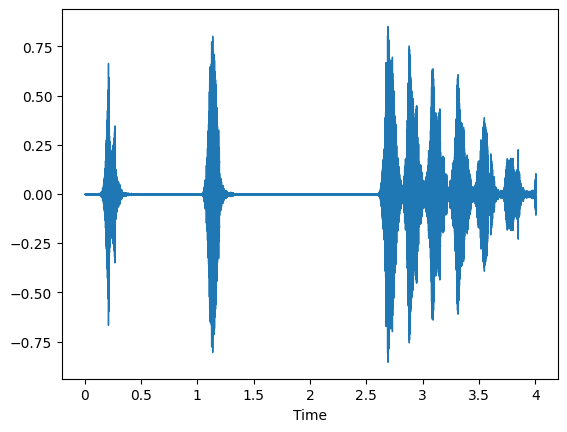

In [13]:
librosa.display.waveshow(y, sr=sr)

In [15]:
filename1 = data_path +'/fold5/197243-3-0-0.wav'
y1, sr1 = librosa.load(filename1)

ipd.Audio(y1, rate=sr1)

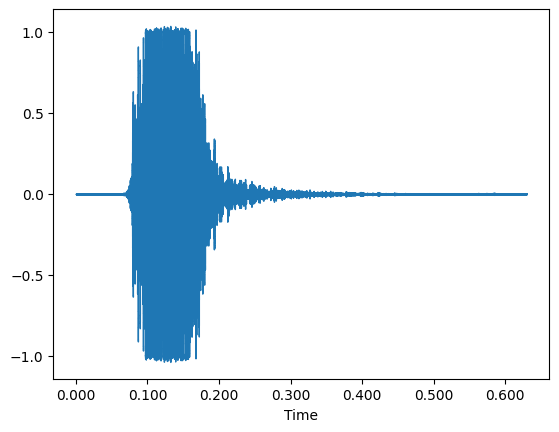

In [10]:
librosa.display.waveshow(y1, sr=sr1)

In [16]:
metadata = pd.read_csv(data_path + '/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [17]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Data Preprocessing

In [20]:
from scipy.io import wavfile as wav

filename2 = data_path + '/fold5/100263-2-0-3.wav'
rate, audio = wav.read(filename2)
audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

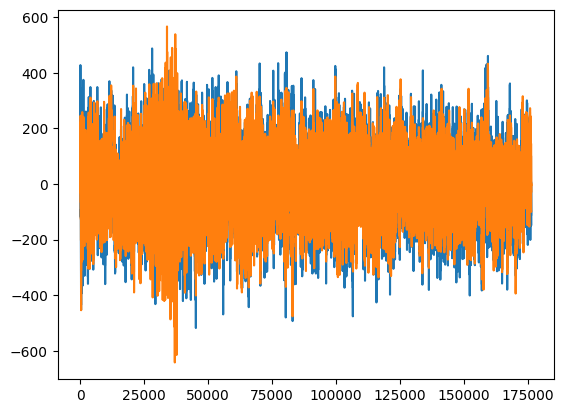

In [21]:
plt.plot(audio)

In [22]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
mfcc.shape

(50, 173)

In [23]:
mfcc

array([[-525.06586  , -519.55695  , -518.64276  , ..., -435.6855   ,
        -385.5867   , -307.79324  ],
       [   9.199923 ,   16.759441 ,   18.103909 , ...,  113.75923  ,
         147.76443  ,  135.58249  ],
       [   8.835556 ,   15.750109 ,   17.259296 , ...,   64.27464  ,
          49.17977  ,   32.84955  ],
       ...,
       [  -1.2839494,   -2.6720011,   -2.8606167, ...,    6.5945377,
           0.6918189,   -1.4426135],
       [  -1.2983356,   -2.6513638,   -2.8284006, ...,    3.934929 ,
          -2.8722343,   -6.6421833],
       [  -1.2524569,   -2.5797617,   -2.7405648, ...,    1.6260489,
          -0.567278 ,   -1.756439 ]], dtype=float32)

In [24]:
def extract_features(filename):
  audio, sample_rate = librosa.load(filename)
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=50)
  mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

  return mfccs_scaled_features

In [25]:
extracted_features = []
for index_num, row in tqdm.tqdm(metadata.iterrows()):
  final_path = os.path.join(data_path, 'fold' + str(row['fold']), row['slice_file_name'])
  class_label = row['class']
  data = extract_features(final_path)
  extracted_features.append([data, class_label])

3549it [00:50, 62.65it/s] c:\Users\SaraImdad\anaconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
8318it [02:03, 88.80it/s] c:\Users\SaraImdad\anaconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
8328it [02:03, 84.51it/s]c:\Users\SaraImdad\anaconda3\envs\audio\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
8732it [02:09, 67.53it/s]


In [26]:
df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
df.head()

,feature,class
0,"[-211.93698, 62.581207, -122.81315, -60.74528,...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578068, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043558, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690277,...",children_playing


In [27]:
X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

In [28]:
X.shape

(8732, 50)

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

y = np.array(df['class'].to_list())
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
y.shape

(8732, 10)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6985, 50)
(1747, 50)
(6985, 10)
(1747, 10)


Model

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics

In [32]:
num_labels = y.shape[1]
num_labels

10

In [40]:
model=Sequential()

model.add(Dense(100,input_shape=(50,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [41]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,810 (495.35 KB)

 Trainable params: 126,810 (495.35 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Training

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

In [44]:
checkpoint = ModelCheckpoint(filepath='saved_models/audio_classification.keras', verbose=1, save_best_only=True)

start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])

duration = datetime.now() - start

print('Training completed in time: ', duration)

Epoch 1/100
193/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1052 - loss: 17.8041
Epoch 1: val_loss improved from inf to 2.29623, saving model to saved_models/audio_classification.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1053 - loss: 16.6367 - val_accuracy: 0.1225 - val_loss: 2.2962
Epoch 2/100
190/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1237 - loss: 2.6829
Epoch 2: val_loss improved from 2.29623 to 2.28773, saving model to saved_models/audio_classification.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1237 - loss: 2.6664 - val_accuracy: 0.1070 - val_loss: 2.2877
Epoch 3/100
202/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1423 - loss: 2.3732
Epoch 3: val_loss improved from 2.28773 to 2.27997, saving model to saved_models/audio_classification.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1420 - loss: 2.3712 - val_accuracy: 0.1070 - val_loss: 2.2800
Epoch 4/100
216/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

Evaluation

In [45]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.681167721748352


Testing

In [46]:
sample_file = 'C:/Users/SaraImdad/Downloads/mixkit-happy-puppy-barks-741.wav'
ipd.Audio(sample_file)

In [47]:
mfcc = extract_features(sample_file)
mfcc.shape

(50,)

In [48]:
pred = model.predict(np.array([mfcc]))
pred_class = np.argmax(pred)
pred_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


3

In [49]:
label = labelencoder.inverse_transform([pred_class])
label[0]

'dog_bark'